In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, math


from skimage import io
from skimage.color import rgb2gray
import skfuzzy as fuzz
from skimage.measure import block_reduce

from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
import cv2
from collections import Counter

from tqdm import tqdm_notebook as tqdm

In [197]:
path = "video"

In [198]:
images = []
label = []
for root, dirnames, filenames in os.walk(path):
    for file in filenames:
        images.append(io.imread(root+ "/" + file))
        label.append(file)


In [199]:
N_IMAGES = len(label)

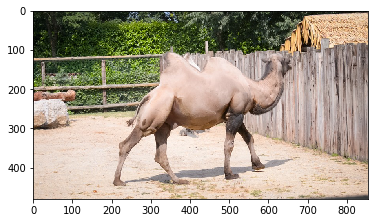

In [200]:
plt.imshow(images[1])

In [201]:
label[1]

'00016.jpg'

In [202]:
images = np.array(images)
images = images/255

In [203]:
images.shape

(79, 480, 854, 3)

## Adding new columns to data

In [204]:
images.shape

(79, 480, 854, 3)

In [205]:
def add_coordinates(img):
    co_ordinates = []
    for i in range(img.shape[0]):
        temp = []
        for j in range(img.shape[1]):
            temp.append([i, j])
        co_ordinates.append(temp)
    co_ordinates = np.array(co_ordinates)
    mod_img = np.c_[img, co_ordinates]
    return mod_img


In [206]:
mod_img = []
for img in tqdm(images):
    mod_img.append(add_coordinates(img))
mod_img = np.array(mod_img)
mod_img.shape

(79, 480, 854, 5)

In [207]:
# Making images into a feature vector, reshaping
mod_img = mod_img.reshape(79, -1, 5)
mod_img.shape

(79, 409920, 5)

## Normalising feature vector

In [208]:
def normalize(img, n_features):
    feature_vector = []
    for i in range(img.shape[0]):
        temp = img[i].reshape(-1, n_features)
        # dealing with columns with max = 0
        safe_max = temp.max(axis=0)
        safe_max[safe_max==0] = 1
        feature_vector.append(temp/safe_max)
    feature_vector = np.array(feature_vector)
    return feature_vector

In [216]:
mod_img = normalize(mod_img, 5)
mod_img.shape

(79, 409920, 5)

### Imaging blurring, maxpool etc.

In [102]:
def get_avg_nearby_2_by_2_pixel(img1):
    subimg1 = img1[::2, ::2]
    subimg2 = img1[1::2, ::2]
    subimg3 = img1[::2, 1::2]
    subimg4 = img1[1::2, 1::2]
    average = np.average([subimg1, subimg2, subimg3, subimg4], 0)
    output = np.zeros(img1.shape)
    output[::2, ::2] = average
    output[1::2, ::2] = average
    output[::2, 1::2] = average
    output[1::2, 1::2] = average
    return output

In [103]:
final_output = images[0].copy()
final_output[:, :, 0] = get_avg_nearby_2_by_2_pixel(images[0][:, :, 0])
final_output[:, :, 1] = get_avg_nearby_2_by_2_pixel(images[0][:, :, 1])
final_output[:, :, 2] = get_avg_nearby_2_by_2_pixel(images[0][:, :, 2])

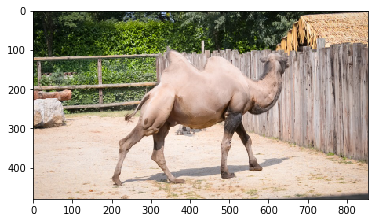

In [104]:
plt.imshow(final_output)

In [55]:
# 2D convolution
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(images[0],-1,kernel)

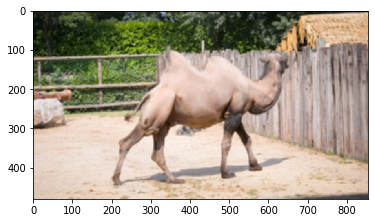

In [60]:
plt.imshow(dst)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


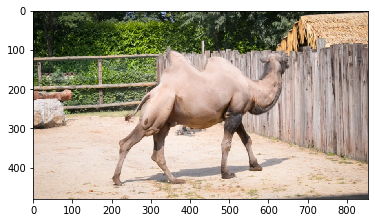

In [32]:
# 2x2 blur
plt.imshow(cv2.blur(images[0], (2, 2)))

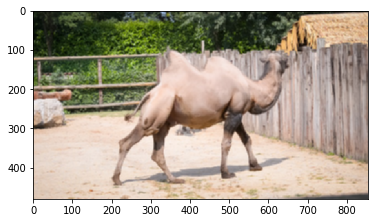

In [34]:
# 5x5 blur
plt.imshow(cv2.blur(images[0], (5, 5)))

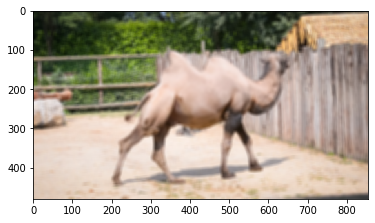

In [54]:
# 10x10 blur
plt.imshow(cv2.blur(images[0], (10, 10)))

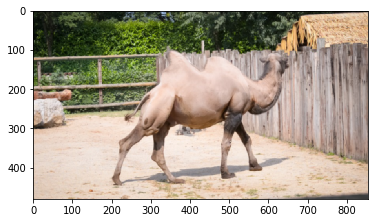

In [40]:
# 5x5 gaussian blur
plt.imshow(cv2.GaussianBlur(images[0],(5,5),0))

## K-Means

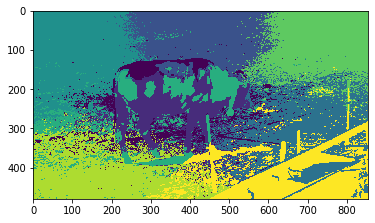

In [46]:
clf = KMeans(n_clusters=9)
clf.fit(feature_vector[6].reshape(-1, 5))
labels = clf.labels_
new_pts = labels.reshape(images[0].shape[0], images[0].shape[1])
plt.imshow(new_pts)

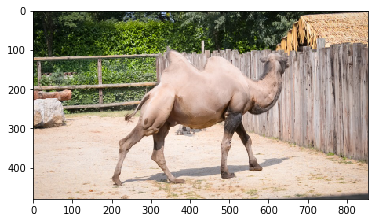

In [47]:
plt.imshow(final_output)

In [53]:
def calculate_wcss(data):
    data = data.reshape(-1, 3)
    wcss = []
    for n in tqdm(range(2, 21)):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

wcss = calculate_wcss(final_output)

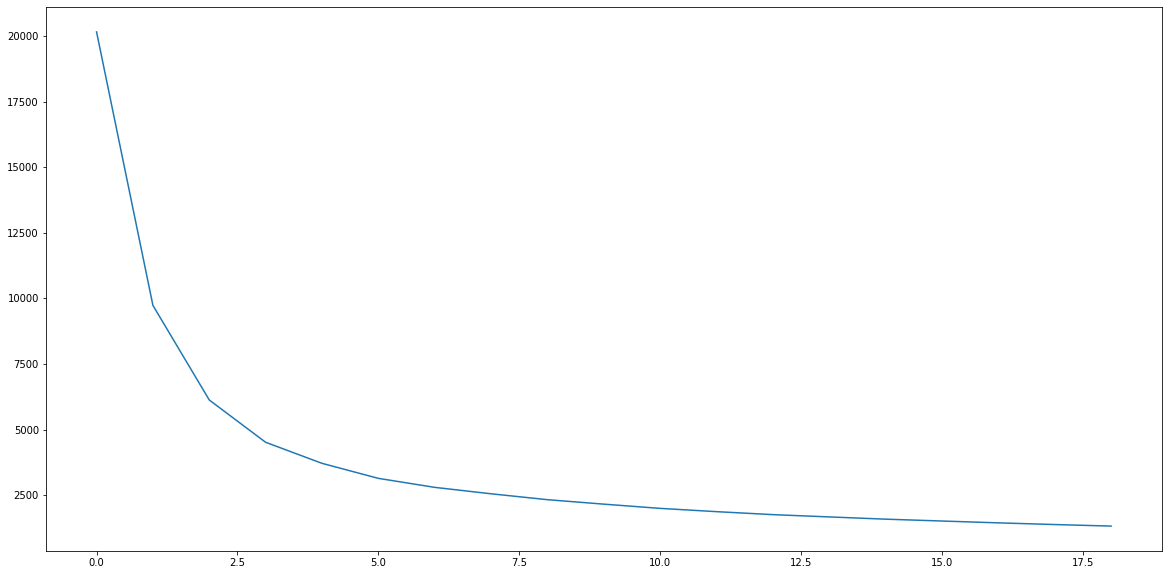

In [56]:
plt.figure(figsize=(20,10))
plt.plot(range(len(wcss)), wcss)

In [57]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in tqdm(range(len(wcss))):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

optimal_n_clusters = optimal_number_of_clusters(wcss)

In [58]:
optimal_n_clusters

5

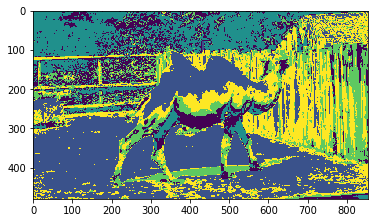

In [64]:
clf = KMeans(n_clusters=optimal_n_clusters)
clf.fit(final_output.reshape(-1, 3))
labels = clf.labels_
new_pts = labels.reshape(images[0].shape[0], images[0].shape[1])
plt.imshow(new_pts)

**Trying making clusters with all those different kinds of blurs and 2d convolutions**

In [127]:
def util_KMeans(data, n_clusters, num_features):
    clf = KMeans(n_clusters=n_clusters)
    clf.fit(data.reshape(-1, num_features))
    labels = clf.labels_
    new_pts = labels.reshape(images[0].shape[0], images[0].shape[1])
    plt.imshow(new_pts)
    
# for plotting lots of subplots in a plot for better visualisation
def util_multi_KMeans(data, num_features):
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
    count = 2
    for row in ax:
        for col in row:
            clf = KMeans(n_clusters=count)
            clf.fit(data.reshape(-1, num_features))
            labels = clf.labels_
            new_pts = labels.reshape(images[0].shape[0], images[0].shape[1])
            col.imshow(new_pts)
            count += 1
    plt.show()
    
    

In [112]:
final_output = images[0].copy()
final_output[:, :, 0] = get_avg_nearby_2_by_2_pixel(images[0][:, :, 0])
final_output[:, :, 1] = get_avg_nearby_2_by_2_pixel(images[0][:, :, 1])
final_output[:, :, 2] = get_avg_nearby_2_by_2_pixel(images[0][:, :, 2])

In [113]:
final_output.shape

(480, 854, 3)

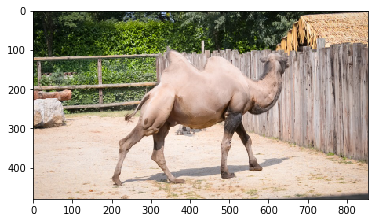

In [114]:
plt.imshow(final_output)

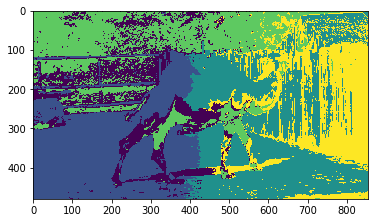

In [115]:
# Adding coordinates 
final_output = add_coordinates(final_output)
final_output = normalize(final_output, 5)
util_KMeans(final_output, 5, 5)

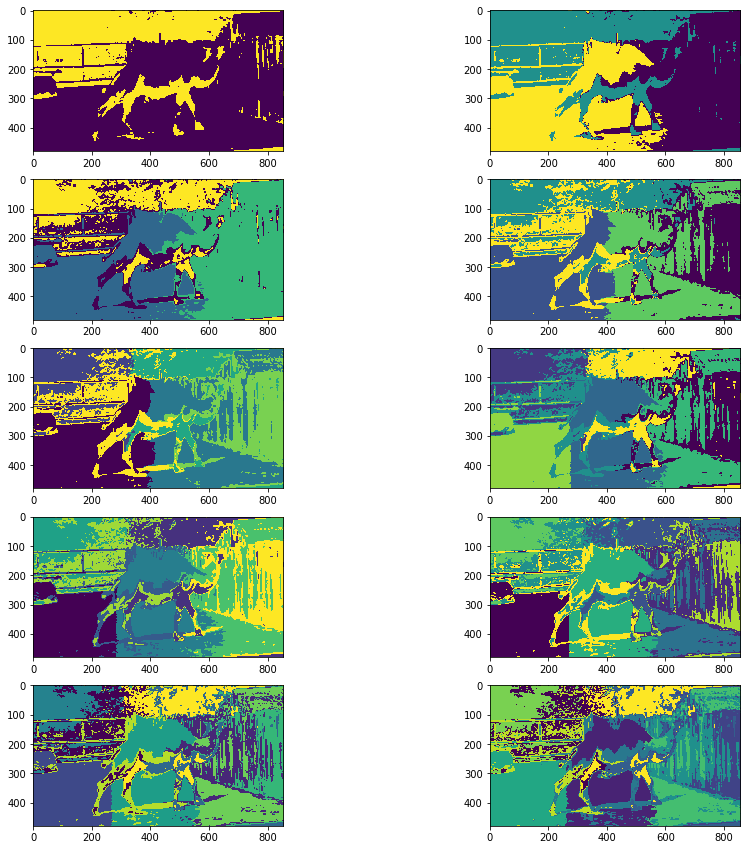

In [128]:
util_multi_KMeans(final_output, 5)

**Trying 2d covolution**

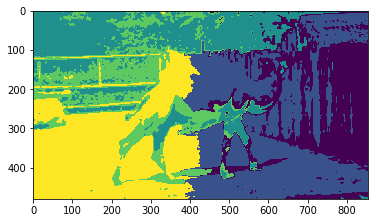

In [118]:
# 2D convolution
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(images[0],-1,kernel)
final_output = add_coordinates(dst)
final_output = normalize(final_output, 5)
util_KMeans(final_output, 5, 5)

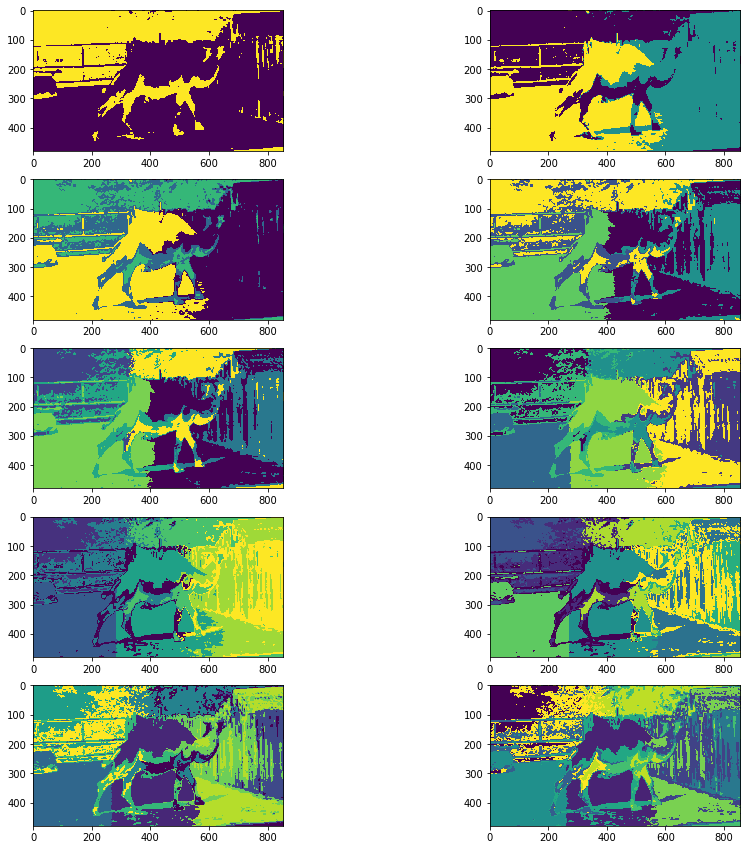

In [129]:
util_multi_KMeans(final_output, 5)

**Blur**

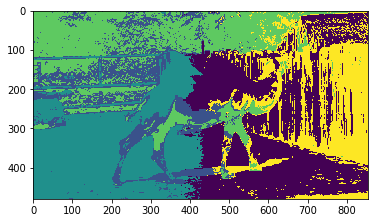

In [132]:
# 2x2 blur
blurred = cv2.blur(images[0], (2, 2))
final_output = add_coordinates(blurred)
final_output = normalize(final_output, 5)
util_KMeans(final_output, 5, 5)

In [133]:
blurred.shape

(480, 854, 3)

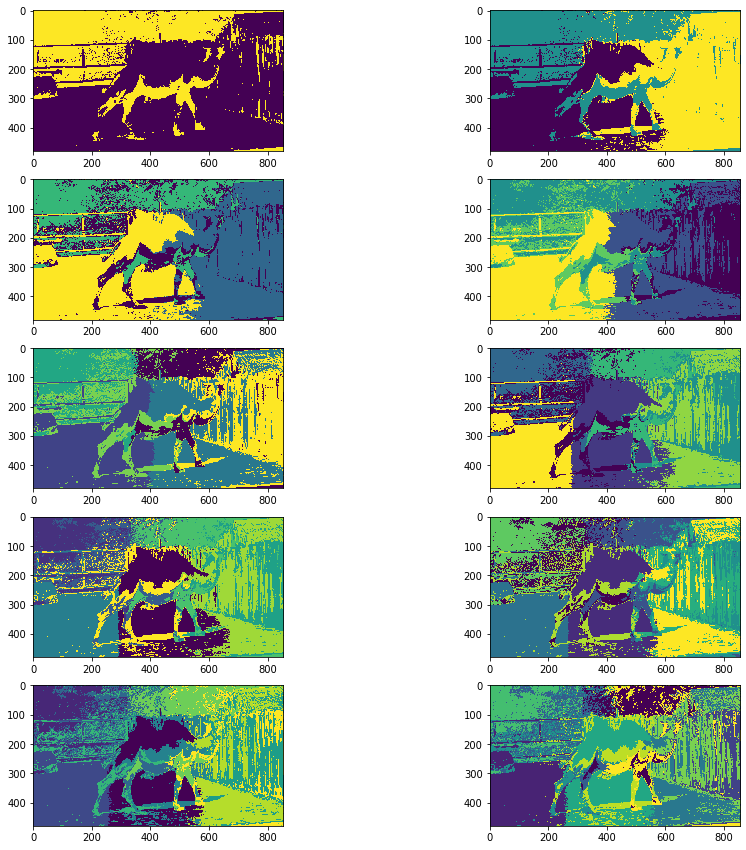

In [134]:
util_multi_KMeans(final_output, 5)

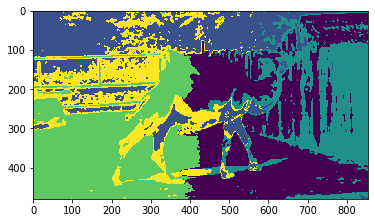

In [135]:
# 5x5 blur
blurred = cv2.blur(images[0], (5, 5))
final_output = add_coordinates(blurred)
final_output = normalize(final_output, 5)
util_KMeans(final_output, 5, 5)

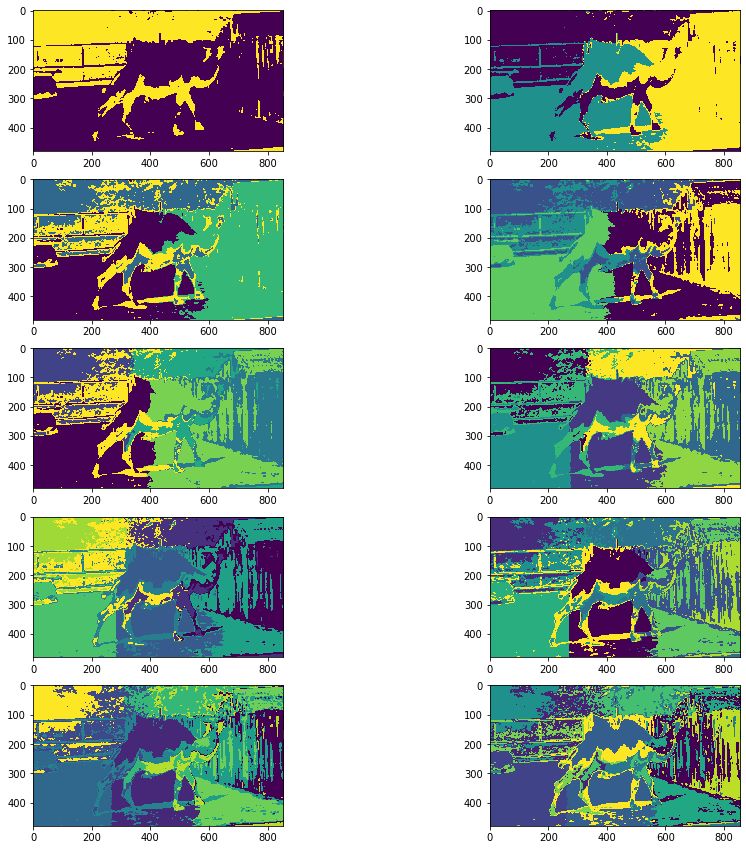

In [136]:
util_multi_KMeans(final_output, 5)

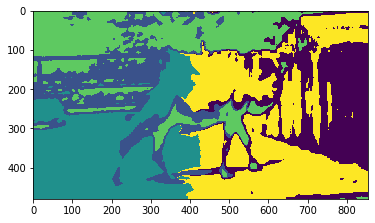

In [137]:
# 10x10 blur
blurred = cv2.blur(images[0], (10, 10))
final_output = add_coordinates(blurred)
final_output = normalize(final_output, 5)
util_KMeans(final_output, 5, 5)

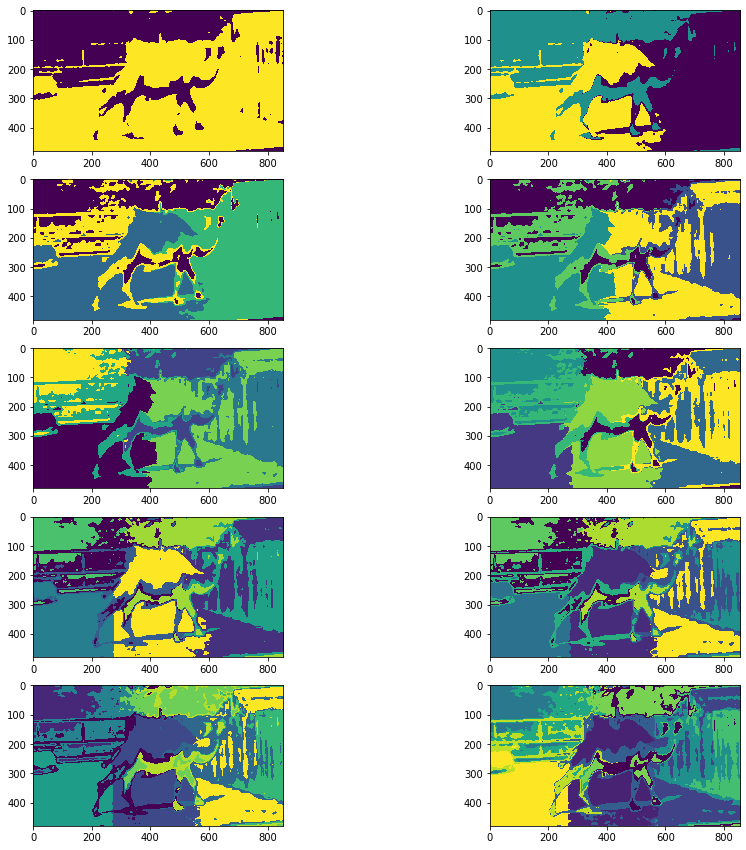

In [138]:
util_multi_KMeans(final_output, 5)

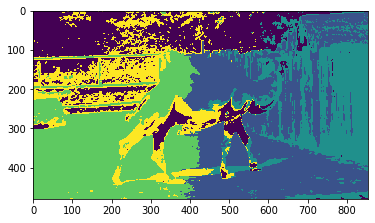

In [141]:
# 5x5 gaussian blur
blurred = cv2.GaussianBlur(images[0],(5,5),0)
final_output = add_coordinates(blurred)
final_output = normalize(final_output, 5)
util_KMeans(final_output, 5, 5)

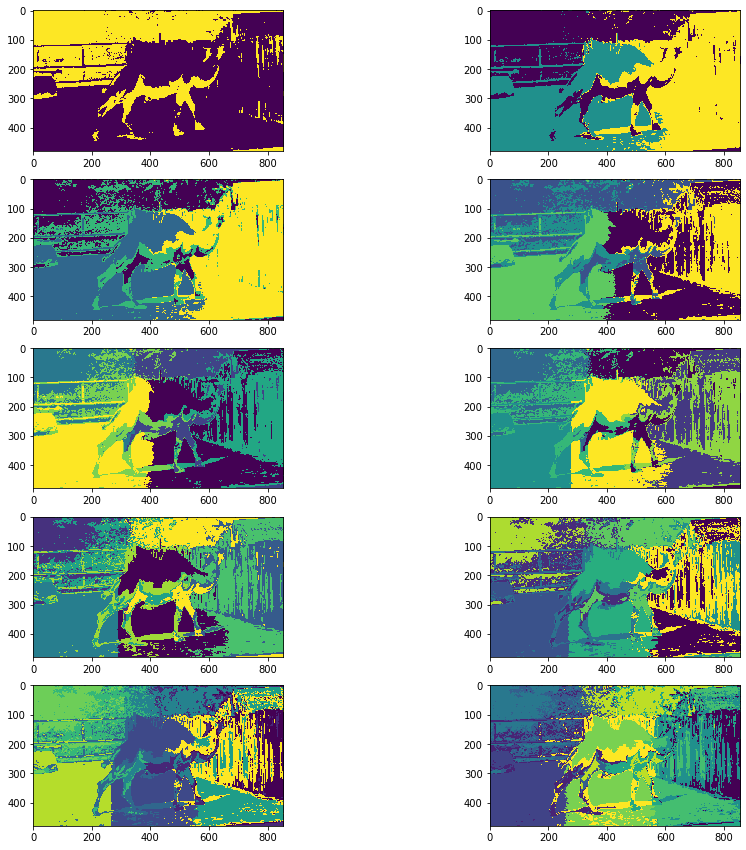

In [142]:
util_multi_KMeans(final_output, 5)

In [210]:
mod_img.shape

(79, 409920, 5)

In [217]:
bin_img = []
n_clusters = 2
for i in tqdm(mod_img):
    clf = KMeans(n_clusters=n_clusters)
    clf.fit(i.reshape(-1, 5))
    labels = clf.labels_
    new_pts = labels.reshape(images[0].shape[0], images[0].shape[1])
    bin_img.append(new_pts)

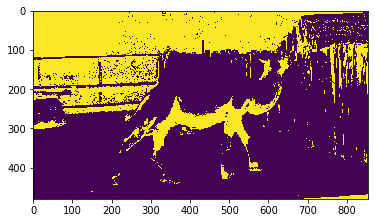

In [218]:
plt.imshow(bin_img[0])

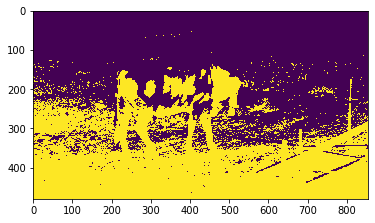

In [221]:
plt.imshow(bin_img[3])

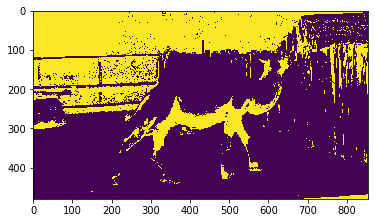

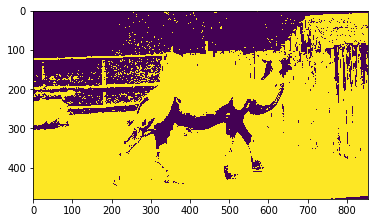

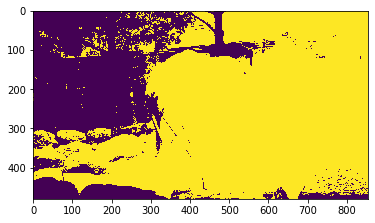

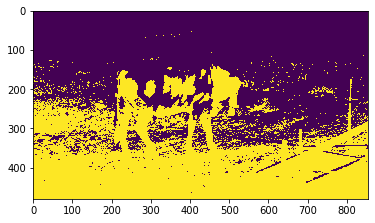

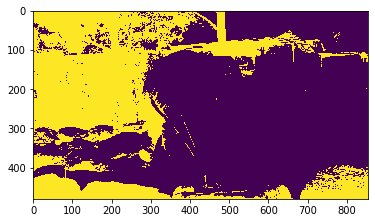

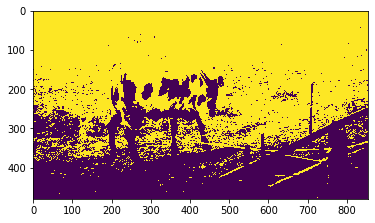

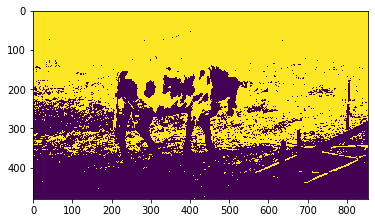

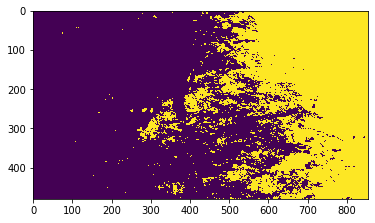

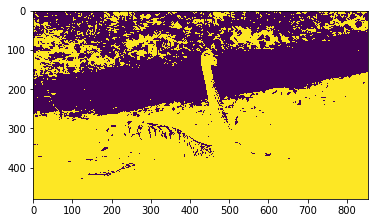

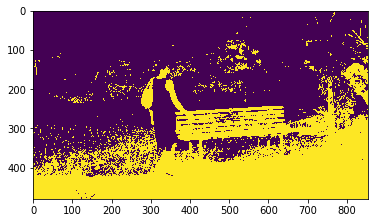

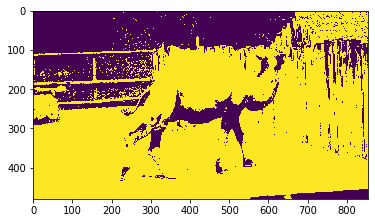

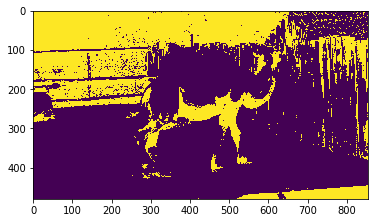

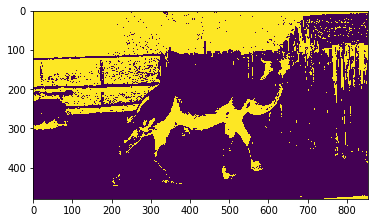

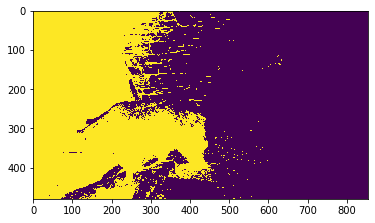

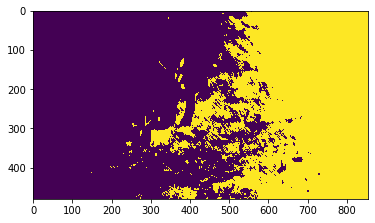

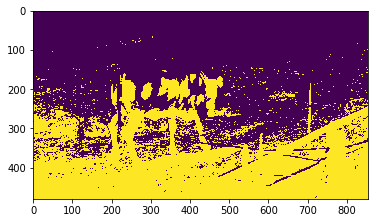

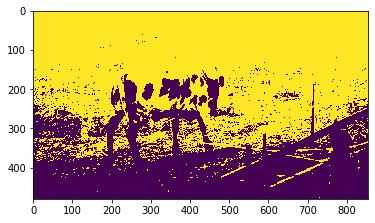

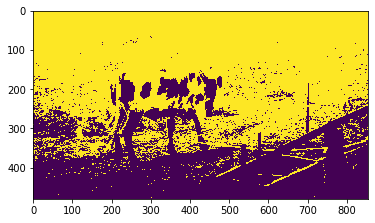

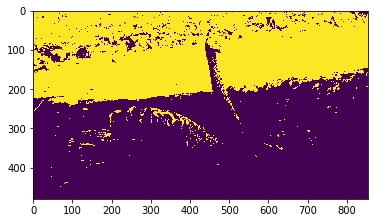

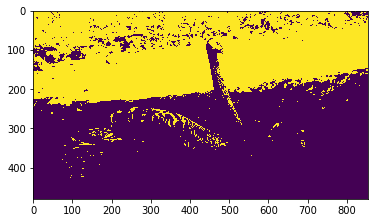

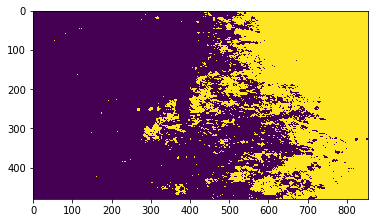

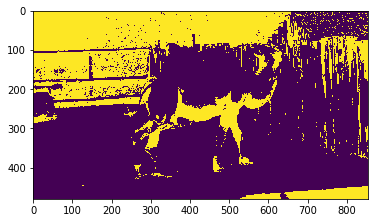

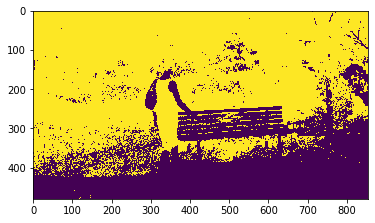

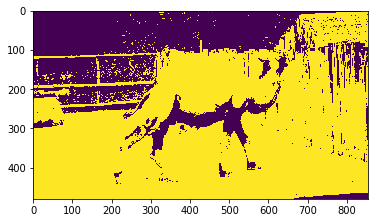

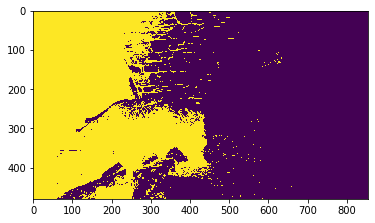

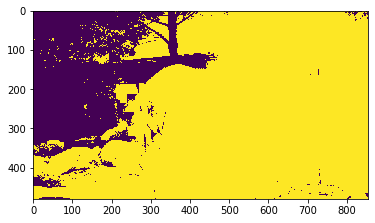

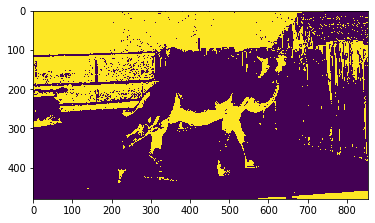

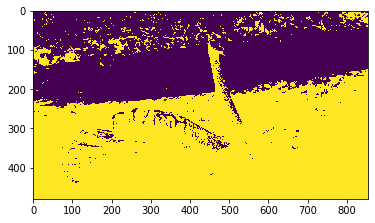

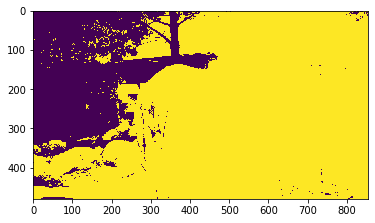

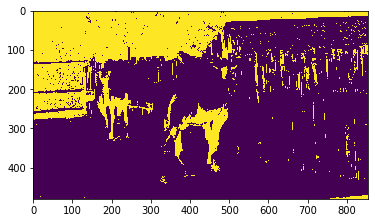

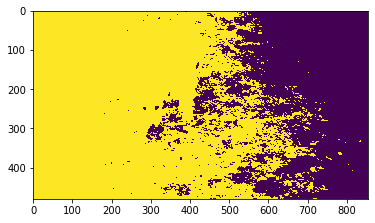

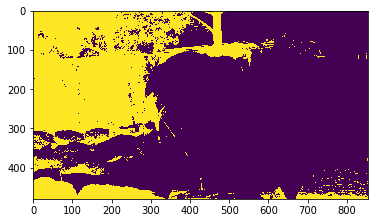

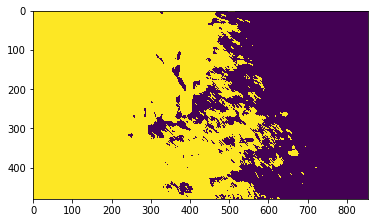

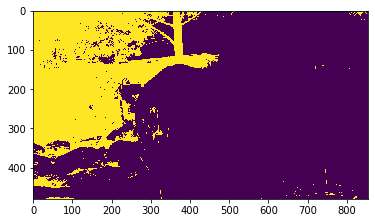

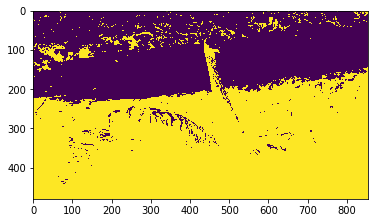

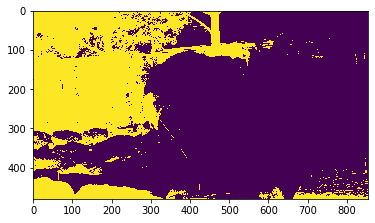

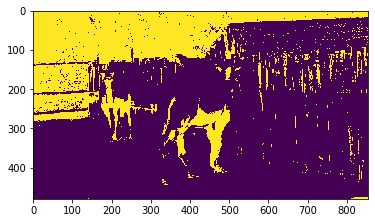

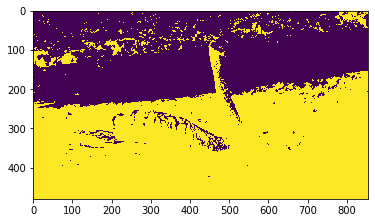

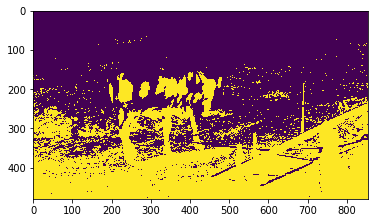

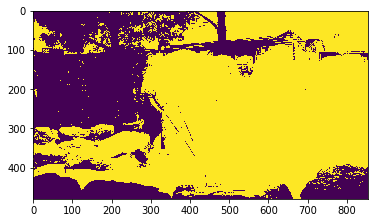

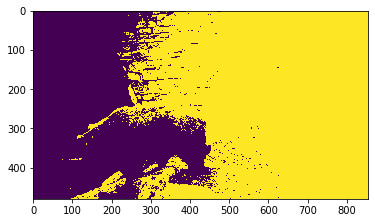

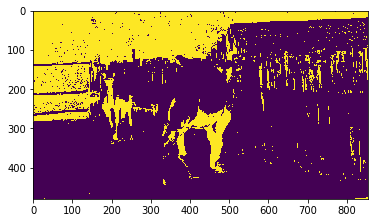

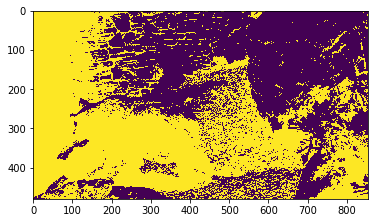

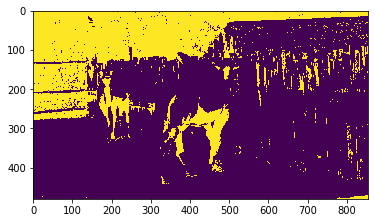

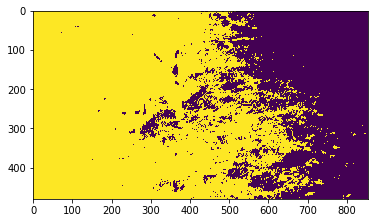

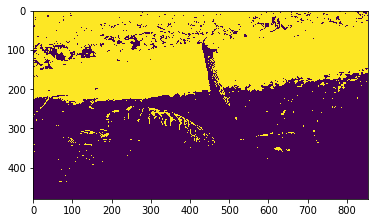

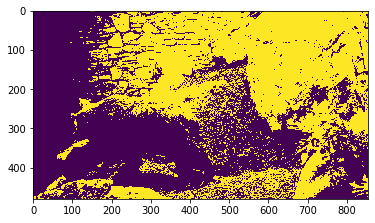

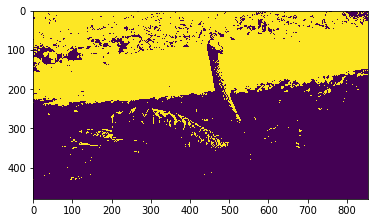

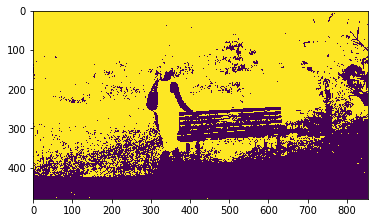

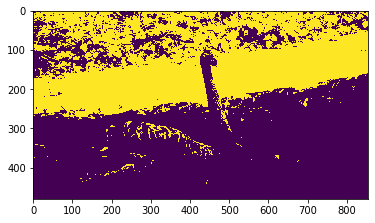

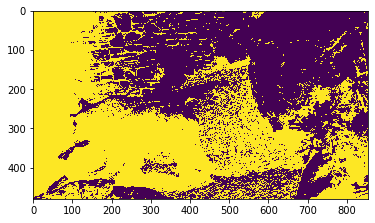

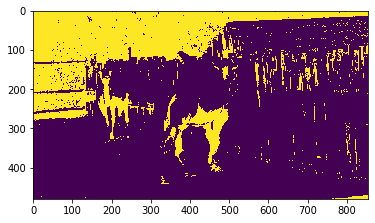

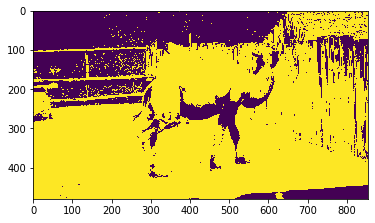

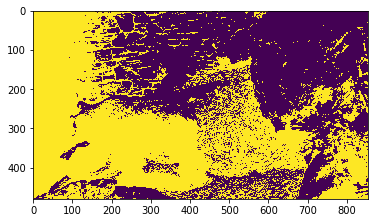

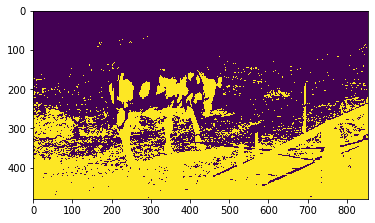

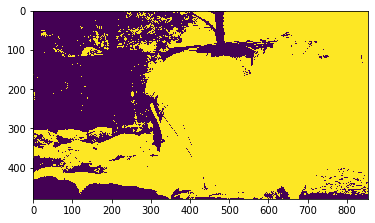

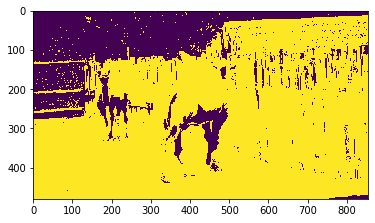

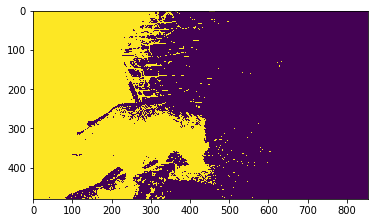

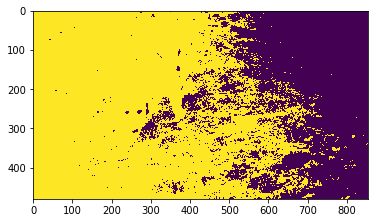

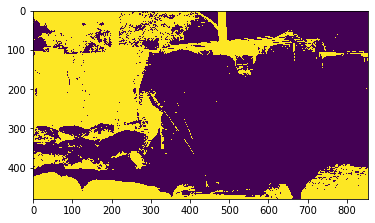

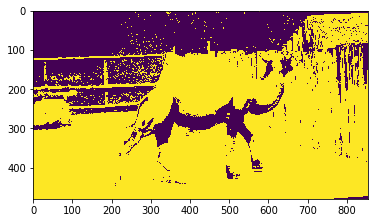

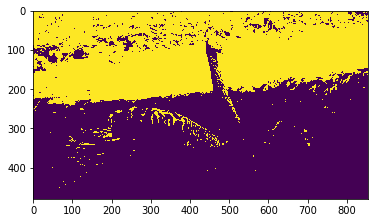

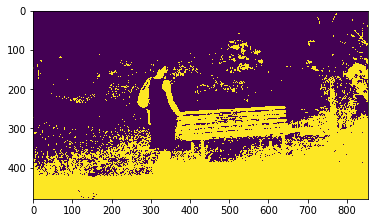

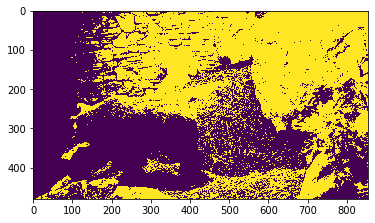

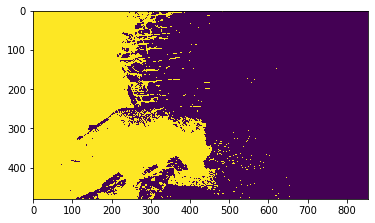

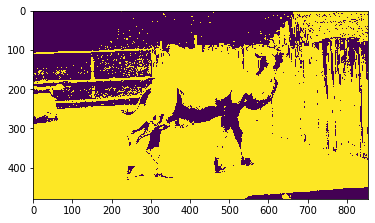

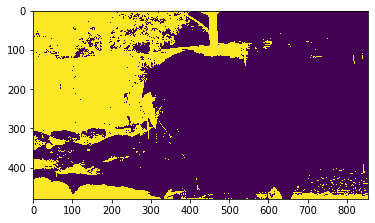

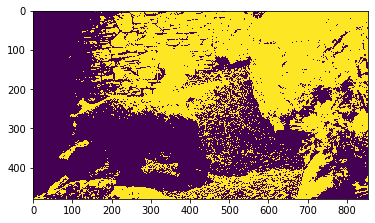

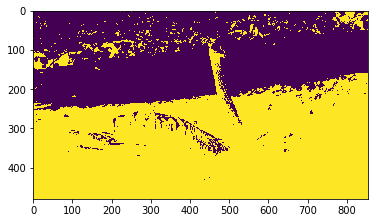

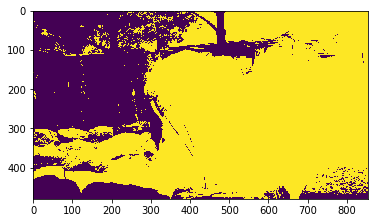

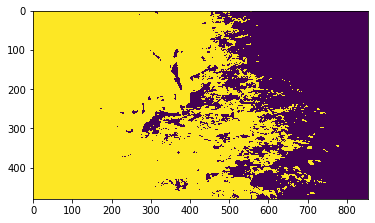

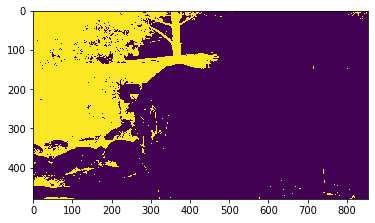

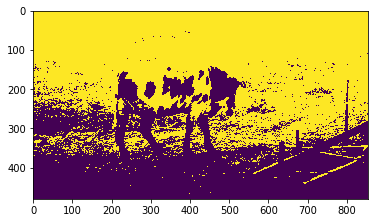

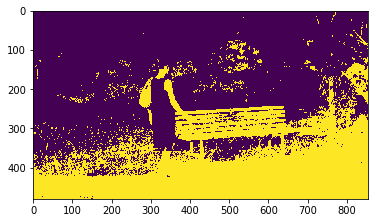

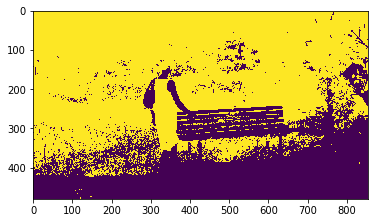

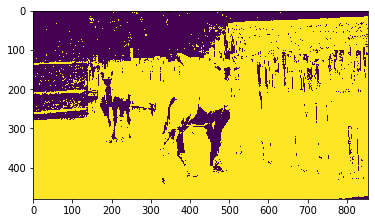

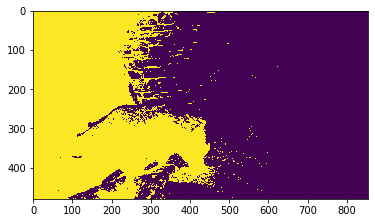

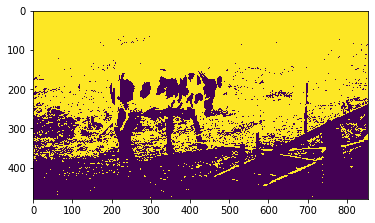

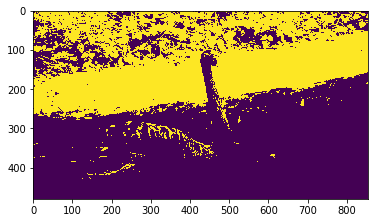

In [224]:
for i in bin_img:
    plt.imshow(i)
    plt.show()

In [ ]:
bin_img = []
n_clusters = 8
for i in tqdm(mod_img):
    clf = KMeans(n_clusters=n_clusters)
    clf.fit(i.reshape(-1, 5))
    labels = clf.labels_
    new_pts = labels.reshape(images[0].shape[0], images[0].shape[1])
    bin_img.append(new_pts)

In [ ]:
most_common,num_most_common = Counter(labels).most_common(1)[0]
for i in range(len(labels)):
    if(labels[i]==most_common):
        labels[i] = 0
    else:
        labels[i] = 255

## Part 2: Temporal segmentation

In [144]:
images.shape

(79, 480, 854, 3)

In [145]:
fv = images.reshape(79, -1)

In [146]:
fv.shape

(79, 1229760)

In [153]:
clf = KMeans(n_clusters=7)
clf.fit(fv)
labels = clf.labels_

In [154]:
labels

array([2, 2, 0, 3, 0, 3, 3, 5, 6, 4, 2, 2, 2, 1, 5, 3, 3, 3, 6, 6, 5, 2,
       4, 2, 1, 0, 2, 6, 0, 2, 5, 0, 5, 0, 6, 0, 2, 6, 3, 0, 1, 2, 1, 2,
       5, 6, 1, 6, 4, 6, 1, 2, 2, 1, 3, 0, 2, 1, 5, 0, 2, 6, 4, 1, 1, 2,
       0, 1, 6, 0, 5, 0, 3, 4, 4, 2, 1, 3, 6], dtype=int32)

In [155]:
# can be calculated but takes too much time
wcss = calculate_wcss(fv)

KeyboardInterrupt: 

In [157]:
optimal_n_clusters = optimal_number_of_clusters(wcss)
# gives optimal clusters 7 but takes too much time for calculate_wss function, and there are actually 7 classes

In [156]:
mp = dict()
for i in range(7):
    mp[i] = []

for i in range(len(labels)):
    mp[labels[i]].append(label[i])

print("Clusters are:")
print(mp)

Clusters are:
{0: ['00046.jpg', '00043.jpg', '00079.jpg', '00078.jpg', '00047.jpg', '00076.jpg', '00048.jpg', '00042.jpg', '00045.jpg', '00041.jpg', '00049.jpg', '00044.jpg', '00077.jpg'], 1: ['00054.jpg', '00055.jpg', '00051.jpg', '00001.jpg', '00000.jpg', '00002.jpg', '00004.jpg', '00053.jpg', '00005.jpg', '00050.jpg', '00003.jpg', '00052.jpg'], 2: ['00018.jpg', '00016.jpg', '00021.jpg', '00024.jpg', '00017.jpg', '00023.jpg', '00019.jpg', '00020.jpg', '00074.jpg', '00070.jpg', '00069.jpg', '00072.jpg', '00073.jpg', '00025.jpg', '00075.jpg', '00015.jpg', '00022.jpg', '00071.jpg'], 3: ['00027.jpg', '00057.jpg', '00028.jpg', '00058.jpg', '00056.jpg', '00059.jpg', '00062.jpg', '00061.jpg', '00029.jpg', '00060.jpg'], 4: ['00065.jpg', '00067.jpg', '00068.jpg', '00063.jpg', '00064.jpg', '00066.jpg'], 5: ['00032.jpg', '00037.jpg', '00031.jpg', '00030.jpg', '00036.jpg', '00034.jpg', '00033.jpg', '00035.jpg'], 6: ['00040.jpg', '00008.jpg', '00010.jpg', '00012.jpg', '00007.jpg', '00013.jpg', '0